# RIP.ie daily death data (v2)

* rip.ie
* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [177]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 500)

In [206]:
df = pd.read_pickle('rip_dn_scrape_processed.pkl')
df=df.dropna(subset=['date'])
df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
#df = df.sort_values('date')
df.index=df.index.astype('int')
df.sort_index()
df['year'] = df.date.dt.year.astype(int)
df['month'] = df.date.dt.month
df['day'] = df.date.dt.dayofyear
df['week'] = df.date.dt.isocalendar().week
df = df[df.year>=2013]
print (len(df))

223665


In [ ]:
nhomes = pd.read_csv('nursing_homes.csv')
#print (nhomes[:10])

def find_nhome(x):
    for i,r in nhomes.iterrows():
        if r.shortname in x.notice and x.county == r.county:
            return r['name']+','+r.county

x=df[:160]
#x['home'] = x.apply(lambda x: find_nhome(x),1)
#print (x)

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
x = 'Peacefully at Sligo University Hospital. Sadly missed by his Loving wife Catherine'
s = list(nhomes.name+' '+nhomes.county)
process.extract(x, s, limit=200)

In [25]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
def check_name(x):
    if type(x) is float:
        return
    if 'née' in x:
        return 'F'    
    s = x.split(' ')[0].strip()
    #handle double names
    s = s.split()
    for n in s:       
        if n.strip("()").lower() in female:            
            return 'F'
        if n.strip("()").lower() in male:    
            return 'M' 
    return 'U'
    
#df['sex'] = df['name'].apply(check_name)
#df.sex.value_counts()

year
2013    12069
2014    18381
2015    26977
2016    28650
2017    28891
2018    30048
2019    30511
2020    32004
2021    16134
dtype: int64


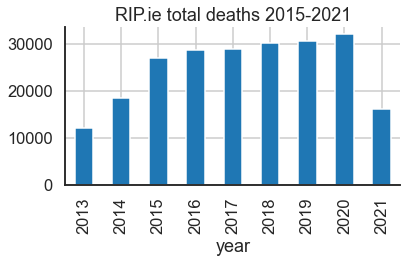

In [207]:
totals = df.groupby('year').agg('size')
print (totals)
ax=totals.plot(kind='bar',grid=True)
plt.title('RIP.ie total deaths 2015-2021')
sns.despine()
plt.tight_layout()
#plt.savefig('ireland_deaths_ripie_summary.png',dpi=100)

year
2013    12069.0
2014    18381.0
2015    26977.0
2016    28650.0
2017    28891.0
2018    30048.0
2019    30511.0
2020    32004.0
2021    16134.0
dtype: float64


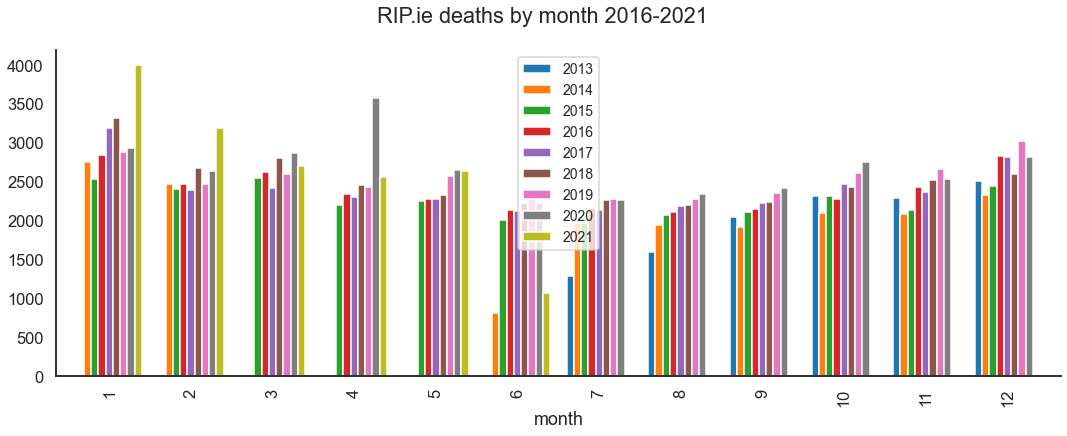

In [208]:
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
print (bymonth.sum())
bymonth.plot(kind='bar',width=.8,figsize=(18,6))
plt.legend(loc=9,fontsize=14)
plt.suptitle('RIP.ie deaths by month 2016-2021')
sns.despine()
plt.savefig('ireland_deaths_ripie_bymonth_v2.png',dpi=150)

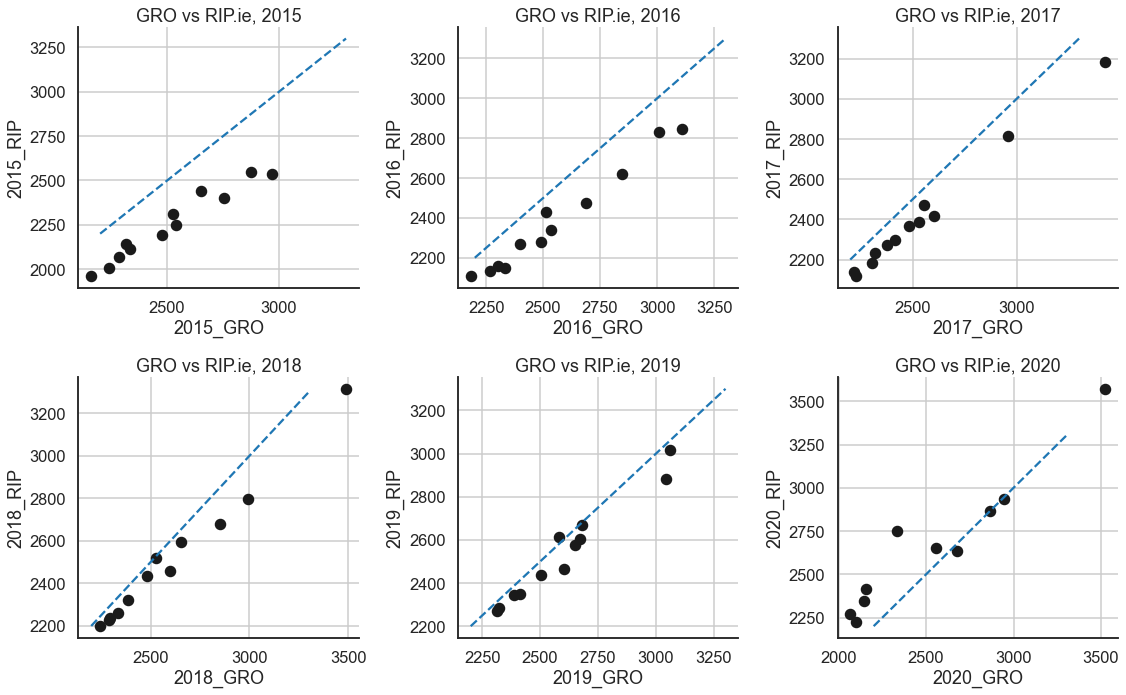

In [218]:
gro = pd.read_csv('gro_deaths.csv')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#b.sum().plot(kind='bar',figsize=(15,6))
#print (b.sum())
f,axs=plt.subplots(2,3,figsize=(16,10))
axs=axs.flat
i=0
for y in range(2015,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2200, 3300], [2200, 3300], ls='--')
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

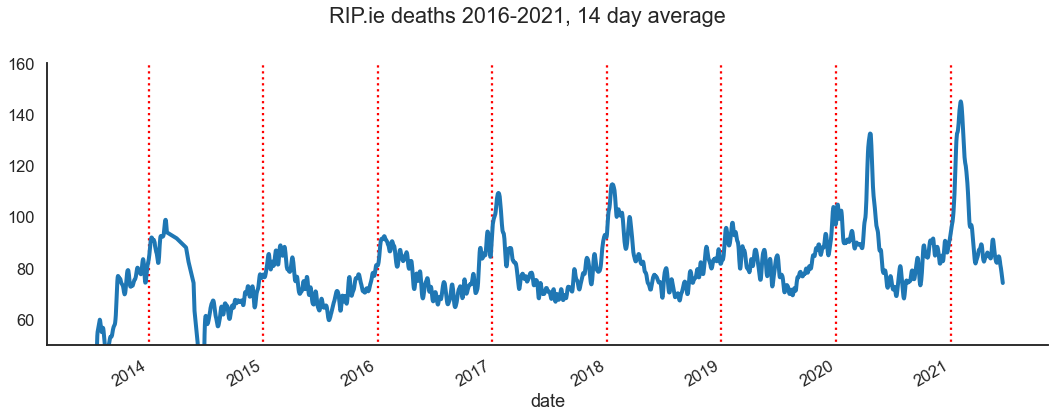

In [212]:
x = df.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=4,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for y in range(2013,2021):
    ax.vlines(pd.to_datetime('%s-12-31' %y),0,160,color='r',ls=':')

plt.suptitle('RIP.ie deaths 2016-2021, 14 day average')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend_v2.png',dpi=150)

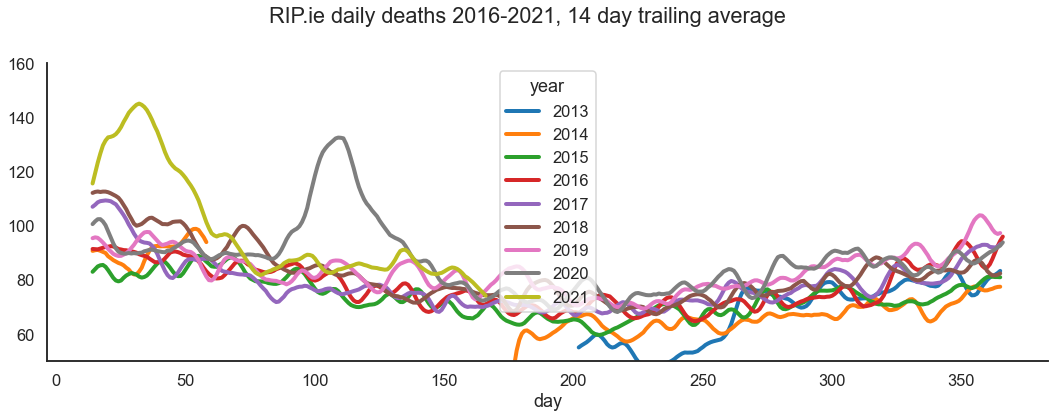

In [213]:
byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
meanday = byday.rolling(window=14,win_type='hamming').mean()
meanday.plot(figsize=(15,6),ylim=(50,160),lw=4)
sns.despine()
plt.suptitle('RIP.ie daily deaths 2016-2021, 14 day trailing average')
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_compared_mean_v2.png',dpi=150)